In [33]:
pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
import os
import re
import glob
import json
import hashlib
import warnings
import numpy as np
import pandas as pd
import faiss
import yara
from pathlib import Path
from datetime import datetime

# ML & NLP
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sentence_transformers import SentenceTransformer
from openai import OpenAI

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)

RULES_DIR = Path("outputs/rules/validated")
DATA_PATH = 'Balanced_Malware_Dataset_500.csv'

In [35]:
warnings.filterwarnings('ignore')
#  1. Load Your Balanced Dataset 
df = pd.read_csv('Balanced_Malware_Dataset_500.csv')

df = df.rename(columns={
    'Description': 'combined_features',
    'SHA256': 'sha256'
})
df['label'] = df['Type'].apply(lambda x: 0 if x == 0 else 1)
df.to_csv('dataset_with_combined_features.csv', index=False)

In [36]:
if not df.empty:
    # 1. Separate Malicious and Benign Data
    malicious_df = df[df['label'] == 1].copy()
    benign_df = df[df['label'] == 0].copy()
    
    train_malware, test_malware = train_test_split(
        malicious_df, 
        test_size=0.2, 
        random_state=42, 
        stratify=malicious_df['Type']
    ) 
    train_df = train_malware
    test_df = pd.concat([test_malware, benign_df])
    print(f"Training set (Knowledge Base): {len(train_df)} samples")
    print(f"   - Contains examples from families: {sorted(train_df['Type'].unique())}")
    
    print(f"Testing set (Evaluation):      {len(test_df)} samples")
    print(f"   - {len(test_malware)} Malicious + {len(benign_df)} Benign")

Training set (Knowledge Base): 2400 samples
   - Contains examples from families: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
Testing set (Evaluation):      2477 samples
   - 600 Malicious + 1877 Benign


In [37]:
# --- 1. Create Benign Datasets ---
# Get all benign samples
benign_df = df[df['label'] == 0].copy()

if benign_df.empty:
    print("Warning: No benign samples found . Cannot build benign index.")
    benign_train_df = pd.DataFrame(columns=df.columns)
    benign_test_df = pd.DataFrame(columns=df.columns)
else:
    # Split benign samples:
    # 80% -> benign_train_df (Use this to build your "Benign Whitelist" / Vector Store)
    # 20% -> benign_test_df  (Use this ONLY for final evaluation)
    benign_train_df, benign_test_df = train_test_split(benign_df, test_size=0.2, random_state=42)
    
    print(f"Benign training set size (knowledge base): {len(benign_train_df)} samples")
    print(f"Benign testing set size (for validation):  {len(benign_test_df)} samples")

if 'test_df' in locals():
    malware_test_only = test_df[test_df['label'] == 1].copy()
    
    test_df = pd.concat([malware_test_only, benign_test_df])
    
    print("-" * 30)
    print(f"Final Evaluation Dataset (test_df) Updated:")
    print(f"Total Samples: {len(test_df)}")
    print(f" - Malicious (Hidden): {len(malware_test_only)}")
    print(f" - Benign (Hidden):    {len(benign_test_df)}")

Benign training set size (knowledge base): 1501 samples
Benign testing set size (for validation):  376 samples
------------------------------
Final Evaluation Dataset (test_df) Updated:
Total Samples: 976
 - Malicious (Hidden): 600
 - Benign (Hidden):    376


In [38]:
# Load the pre-trained SentenceTransformer model
from sentence_transformers import SentenceTransformer  
model = SentenceTransformer('all-MiniLM-L6-v2')

#  Embed Malicious Samples (Positive Examples) 
if 'train_df' in locals() and not train_df.empty:
    print("Generating embeddings for the MALICIOUS training set")
    # This creates the vector database for Malware
    train_embeddings = model.encode(train_df['combined_features'].tolist(), show_progress_bar=True)
    print(f"Malicious embeddings generated. Shape: {train_embeddings.shape}")

#  Embed Benign Samples (Negative Examples) 
if 'benign_train_df' in locals() and not benign_train_df.empty:
    print("Generating embeddings for the BENIGN training set")
    benign_embeddings = model.encode(benign_train_df['combined_features'].tolist(), show_progress_bar=True)
    print(f"Benign embeddings generated. Shape: {benign_embeddings.shape}")

Generating embeddings for the MALICIOUS training set


Batches: 100%|██████████| 75/75 [00:59<00:00,  1.26it/s]


Malicious embeddings generated. Shape: (2400, 384)
Generating embeddings for the BENIGN training set


Batches: 100%|██████████| 47/47 [00:39<00:00,  1.20it/s]

Benign embeddings generated. Shape: (1501, 384)


In [39]:
#  BUILD FAISS INDICES

#  A. Build Malware Index (Positive Knowledge Base) 
if 'train_embeddings' in locals():
    d = train_embeddings.shape[1]

    malware_index = faiss.IndexFlatL2(d)
    
    malware_index.add(np.array(train_embeddings).astype('float32'))
    
    print(f" Malware FAISS index built: {malware_index.ntotal} vectors.")
else:
    print(" Malware embeddings not found. Malware Index not built.")

# --- B. Build Benign Index (Negative Knowledge Base) ---
if 'benign_embeddings' in locals():
    d = benign_embeddings.shape[1]
    
    benign_index = faiss.IndexFlatL2(d)
    
    benign_index.add(np.array(benign_embeddings).astype('float32'))
    
    print(f" Benign FAISS index built: {benign_index.ntotal} vectors.")
else:
    print(" Benign embeddings not found. Benign Index not built.")

 Malware FAISS index built: 2400 vectors.
 Benign FAISS index built: 1501 vectors.


In [40]:

if 'train_df' in locals() and not train_df.empty:

    malware_subset = train_df 

    if len(malware_subset) == 0:
        print(" No malware sample found in train_df")
        print("   Cannot perform retrieval.")
    else:
        new_malware_sample = malware_subset.iloc[2]  
        target_sha = new_malware_sample['sha256']

        print(f"--- Selected Malware Sample (From Knowledge Base) ---")
        print(f"SHA256: {target_sha}")
        print(f"Family Type: {new_malware_sample['Type']}")
        print(f"Features: {new_malware_sample['combined_features'][:200]}...\n")

        # Create embedding for the new malware sample
        new_malware_embedding = model.encode([new_malware_sample['combined_features']])
        new_malware_embedding = np.array(new_malware_embedding).astype('float32')

        K_NEIGHBORS = 4

        if 'malware_index' in locals():
            mal_distances, mal_indices = malware_index.search(new_malware_embedding, K_NEIGHBORS)
            
            mal_idx_flat = mal_indices[0]
            mal_dist_flat = mal_distances[0]

            valid_mal_mask = mal_idx_flat != -1
            final_mal_indices = mal_idx_flat[valid_mal_mask]
            
            # Retrieve the rows
            raw_retrieved = train_df.iloc[final_mal_indices]
            retrieved_mal_samples = raw_retrieved[raw_retrieved['sha256'] != target_sha]
            retrieved_mal_samples = retrieved_mal_samples.head(3)
            if retrieved_mal_samples.empty:
                print("--- No similar distinct MALICIOUS samples found ---")
            else:
                print(f"--- Found {len(retrieved_mal_samples)} Similar distinct MALICIOUS Samples ---")
                
                
                for i, (idx, row) in enumerate(retrieved_mal_samples.iterrows()):
                    print(f"   [{i+1}] Type: {row['Type']} | SHA: {row['sha256']}")
        else:
            print(" 'malware_index' not found.")
            retrieved_mal_samples = pd.DataFrame()

        if 'benign_index' in locals():
            ben_distances, ben_indices = benign_index.search(new_malware_embedding, 3) 
            
            ben_idx_flat = ben_indices[0]
            ben_dist_flat = ben_distances[0]

            valid_ben_mask = ben_idx_flat != -1
            final_ben_indices = ben_idx_flat[valid_ben_mask]
            final_ben_distances = ben_dist_flat[valid_ben_mask]

            if len(final_ben_indices) == 0:
                print("\n--- No similar BENIGN samples found ---")
                retrieved_benign_samples = pd.DataFrame()
            else:
                retrieved_benign_samples = benign_train_df.iloc[final_ben_indices]
                print(f"\n--- Found {len(retrieved_benign_samples)} Similar BENIGN Samples (Negative Context) ---")
                
                for i, (idx, row) in enumerate(retrieved_benign_samples.iterrows()):
                    dist_val_b = final_ben_distances[i]
                    print(f"   [{i+1}] SHA: {row['sha256']} (Dist: {dist_val_b:.4f})")
        else:
            print("\n 'benign_index' not found.")
            retrieved_benign_samples = pd.DataFrame()

else:
    print("Please run previous cells to initialize dataframes.")

--- Selected Malware Sample (From Knowledge Base) ---
SHA256: 096fc162ed138cc3d9ee62631325c0d7d2957d6a1b7eec705da59004b83fd6c8
Family Type: 1
Features: API Functions: regclosekey, regsetvalueexw, regcreatekeyexw, regqueryvalueexw, regopenkeyexw, adjusttokenprivileges, openprocesstoken, getexitcodeprocess, getversion, expandenvironmentstringsw, getpro...

--- Found 3 Similar distinct MALICIOUS Samples ---
   [1] Type: 4 | SHA: 6e662c3d403396c5bfec2b051dd49b39662c3ff80f39c16ece3ebc2e1c469208
   [2] Type: 4 | SHA: 70e14ddf23a5fe3d69cc50752fcc491aa2964a2cfee3d48caf182244929f9953
   [3] Type: 1 | SHA: 7f1c74a077fa497b902e29cf16f59377faa82d688d5ed967e68ba7c748756e5a

--- Found 3 Similar BENIGN Samples (Negative Context) ---
   [1] SHA: bec923a69b816cc959ebfbd59fe3b742e32a5174fc388e75f6caa2f9dc965edf (Dist: 0.0000)
   [2] SHA: 82e0d1bb7a8b81a0b35b8c031bb732a7776c6c8833b2a1637af4fa4b9ea6ad21 (Dist: 0.0151)
   [3] SHA: 77e5a7191c67661016b9724de27702246421684e21fe203db08c3484ab36c30d (Dist: 0.01

In [41]:
# 4.  Prompt Construction 

def construct_benign_aware_prompt(new_sample, retrieved_mal_samples, retrieved_benign_samples):
    """
    Constructs a detailed prompt for the LLM, including Positive (malicious)
    and Negative (benign) context, with STRICT guidelines against overfitting.
    """
    
    prompt = """
You are an expert malware analyst. Your task is to create a comprehensive YARA rule to detect the new malware sample described below.

GUIDELINES:
1. **ANALYSIS:** Compare the 'New Malware Sample' with 'Malware Neighbors' to find shared capabilities (APIs, Strings).
2. **STRICT PROHIBITION (NO OVERFITTING):** You are FORBIDDEN from generating strings based on Volatile PE Headers. These change on every compilation.
   - **DO NOT USE:** "TimeDateStamp", "CheckSum", "SizeOfImage", "AddressOfEntryPoint", "BaseOfCode", "ImageBase", "SizeOfCode", "SizeOfStackReserve", "SizeOfHeapReserve".
3. **BENIGN FILTER (NO FALSE POSITIVES):** - Do NOT create a rule that triggers solely on generic .NET artifacts like "mscoree.dll", "corexemain", or "kernel32.dll". 
   - These appear in the 'Negative Context' (Benign Files). You MUST combine them with specific behavioral indicators.
4. **LOGIC REQUIREMENT:** - Focus on **BEHAVIORAL** indicators (e.g., Native API usage in .NET, Injection patterns, Persistence).
   - If the sample is .NET, look for P/Invoke strings (e.g., "VirtualAlloc", "WriteProcessMemory") that do not appear in Benign Neighbors.
5. **CONSTRAINT:** The target is a text log. Use pure string matching (e.g., $a = "virtualalloc"). Do NOT use binary modules (import "pe").
6. Output ONLY the YARA rule code block.

--- DATA START ---

**[New Malware Sample to Analyze]**
"""
    # TARGET 
    prompt += f"- SHA256: {new_sample['sha256']}\n"
    prompt += f"- TECHNICAL FEATURES: {new_sample['combined_features']}\n\n"

    #  POSITIVE CONTEXT: Retrieved Similar Malware 
    prompt += "**[Positive Context - Retrieved Similar Malware]**\n"
    prompt += "(Look for shared patterns between the Target and these files)\n"
    
    if not retrieved_mal_samples.empty:
        for i, (idx, row) in enumerate(retrieved_mal_samples.iterrows()):
            prompt += f"\n[Malware Neighbor #{i+1}]\n"
            prompt += f"- SHA256: {row['sha256']}\n"
            prompt += f"- Features: {row['combined_features']}\n" 
    else:
        prompt += "- No similar malicious samples were found.\n\n"

    #  NEGATIVE CONTEXT: Retrieved Similar Benign Files 
    prompt += "\n**[Negative Context - Retrieved Similar Benign Files]**\n"
    prompt += "(CRITICAL: These are SAFE files. Do NOT write a rule that matches features unique to these.)\n"
    
    if not retrieved_benign_samples.empty:
        for i, (idx, row) in enumerate(retrieved_benign_samples.iterrows()):
            prompt += f"\n[Benign Neighbor #{i+1}]\n"
            prompt += f"- SHA256: {row['sha256']}\n"
            prompt += f"- Features: {row['combined_features']}\n"
    else:
        prompt += "- No similar benign samples were found.\n\n"
        

    prompt += """
--- DATA END ---

Based on the data above, generate the text-based YARA rule now.
"""
    return prompt

# --- Execution & Verification ---
if 'new_malware_sample' in locals() and 'retrieved_mal_samples' in locals() and 'retrieved_benign_samples' in locals():
    final_prompt = construct_benign_aware_prompt(new_malware_sample, retrieved_mal_samples, retrieved_benign_samples)
    print("="*40)
    print(" FULL LLM PROMPT ")
    print("="*40)
    print(final_prompt)
    print("="*40)
else:
    print("Please run the previous Retrieval cell first.")

 FULL LLM PROMPT 

You are an expert malware analyst. Your task is to create a comprehensive YARA rule to detect the new malware sample described below.

GUIDELINES:
1. **ANALYSIS:** Compare the 'New Malware Sample' with 'Malware Neighbors' to find shared capabilities (APIs, Strings).
2. **STRICT PROHIBITION (NO OVERFITTING):** You are FORBIDDEN from generating strings based on Volatile PE Headers. These change on every compilation.
   - **DO NOT USE:** "TimeDateStamp", "CheckSum", "SizeOfImage", "AddressOfEntryPoint", "BaseOfCode", "ImageBase", "SizeOfCode", "SizeOfStackReserve", "SizeOfHeapReserve".
3. **BENIGN FILTER (NO FALSE POSITIVES):** - Do NOT create a rule that triggers solely on generic .NET artifacts like "mscoree.dll", "corexemain", or "kernel32.dll". 
   - These appear in the 'Negative Context' (Benign Files). You MUST combine them with specific behavioral indicators.
4. **LOGIC REQUIREMENT:** - Focus on **BEHAVIORAL** indicators (e.g., Native API usage in .NET, Injection

In [ ]:

client = OpenAI(api_key="YOUR_OPENAI_API_KEY")


In [11]:
def get_gpt5_response(prompt, model="gpt-5"):
    
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a helpful and intelligent assistant."},
                {"role": "user", "content": prompt}
            ]
        )
        return response.choices[0].message.content.strip()

    except Exception as e:
        return f" Error: {e}"


In [12]:
result = get_gpt5_response(final_prompt)
print(result)

rule win32_malware_gui_priv_accel_resource_isbad_winexec {
    meta:
        description = "Detects Win32 malware family using ANSI GUI/accelerator APIs, resource triad, isbad* checks, WinExec, ExitWindowsEx, and timer APIs"
        author = "AI Malware Analyst"
        date = "2025-12-09"
        sha256 = "9b045f7efedbf3ddff5f089a205c3c4c7725ab6aa38e859da5bc7848a2e2bcb0"
        reference = "Behavioral API pattern from sample and close neighbors"
    strings:
        $isbad1 = "isbadwriteptr" nocase ascii
        $isbad2 = "isbadreadptr" nocase ascii
        $isbad3 = "isbadcodeptr" nocase ascii

        $exitwin = "exitwindowsex" nocase ascii
        $winexec = "winexec" nocase ascii

        $accel1 = "loadacceleratorsa" nocase ascii
        $accel2 = "translateacceleratora" nocase ascii

        $dlg1 = "setdlgitemtexta" nocase ascii
        $dlg2 = "dialogboxparama" nocase ascii

        $winclass1 = "registerclassexa" nocase ascii
        $winclass2 = "createwindowexa" nocase asc

In [42]:
X = np.array(train_embeddings)

print(f"Clustering {len(X)} samples using RuleLLM methodology (K-Means on Vectors)...")

NUM_CLUSTERS = 100

kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)

train_df['cluster_id'] = labels


print(f"\n Grouped {len(train_df)} samples into {NUM_CLUSTERS} clusters.")

# Count samples per cluster
cluster_counts = train_df['cluster_id'].value_counts()
print("\nTop 5 Largest Malware Families (Clusters):")
print(cluster_counts.head())

# --- 4. SELECT REPRESENTATIVES ---
# rules for the CENTER of each cluster.
representative_indices = []

for cluster_num in range(NUM_CLUSTERS):
    # Get all samples in this cluster
    cluster_indices = np.where(labels == cluster_num)[0]
    
    # Calculate distances to the cluster center
    center = kmeans.cluster_centers_[cluster_num]
    distances = np.linalg.norm(X[cluster_indices] - center, axis=1)
    
    # Find the sample closest to the center (The most "average" malware of the group)
    center_sample_idx = cluster_indices[np.argmin(distances)]
    representative_indices.append(center_sample_idx)

print(f"\nSelected {len(representative_indices)} representative samples for Rule Generation.")

Clustering 2400 samples using RuleLLM methodology (K-Means on Vectors)...

 Grouped 2400 samples into 100 clusters.

Top 5 Largest Malware Families (Clusters):
cluster_id
22    232
40    175
47    152
84    106
71    105
Name: count, dtype: int64

Selected 100 representative samples for Rule Generation.


In [50]:


# --- CONFIGURATION ---
RULES_TO_DISPLAY = len(cluster_counts) 
sorted_cluster_ids = cluster_counts.index.tolist()

print(f"--- Displaying ALL {RULES_TO_DISPLAY} Prompts (Optimized) ---\n")

for i in range(RULES_TO_DISPLAY):
    cluster_id = sorted_cluster_ids[i]
    
    # 1. Get Representative Sample
    rep_pos_idx = representative_indices[cluster_id] 
    representative_sample = train_df.iloc[rep_pos_idx]
    
    # Prepare vector for KNN search
    rep_vec = np.array([train_embeddings[rep_pos_idx]]).astype('float32')
    
    # 2. Get Positive Context (Nearest Siblings)
    # Search for 4 neighbors to ensure we have 3 distinct samples after filtering self
    D_mal, I_mal = malware_index.search(rep_vec, 4)
    sibling_indices = I_mal[0]
    
    # Filter out the representative itself
    real_sibling_indices = [idx for idx in sibling_indices if idx != rep_pos_idx][:3]
    siblings = train_df.iloc[real_sibling_indices]
    
    # 3. Get Negative Context (Nearest Benign)
    D_ben, I_ben = benign_index.search(rep_vec, 3)
    negative_context = benign_train_df.iloc[I_ben[0]]
    
    # 4. Construct Prompt
    prompt_text = construct_benign_aware_prompt(
        representative_sample, 
        siblings, 
        negative_context
    )
    
    # 5. Output
    print(f"{'='*80}")
    print(f" PROMPT {i+1} OF {RULES_TO_DISPLAY} | Cluster #{cluster_id} (Size: {cluster_counts[cluster_id]})")
    print(f"   Target Family Type: {representative_sample['Type']}")
    print(f"   SHA: {representative_sample['sha256']}")
    print(f"{'='*80}\n")
    
    print(prompt_text)
    
    print(f"\n{'='*80}")
    print(f"END OF PROMPT {i+1} - COPY CONTENT ABOVE")
    print(f"{'='*80}\n\n\n")

--- Displaying ALL 100 Prompts (Optimized) ---

 PROMPT 1 OF 100 | Cluster #22 (Size: 232)
   Target Family Type: 6
   SHA: c9dafbfc46ddc581f8ec2ba7f4333d296a5f8838bc0d0e0d8b4858b40014479d


You are an expert malware analyst. Your task is to create a comprehensive YARA rule to detect the new malware sample described below.

GUIDELINES:
1. **ANALYSIS:** Compare the 'New Malware Sample' with 'Malware Neighbors' to find shared capabilities (APIs, Strings).
2. **STRICT PROHIBITION (NO OVERFITTING):** You are FORBIDDEN from generating strings based on Volatile PE Headers. These change on every compilation.
   - **DO NOT USE:** "TimeDateStamp", "CheckSum", "SizeOfImage", "AddressOfEntryPoint", "BaseOfCode", "ImageBase", "SizeOfCode", "SizeOfStackReserve", "SizeOfHeapReserve".
3. **BENIGN FILTER (NO FALSE POSITIVES):** - Do NOT create a rule that triggers solely on generic .NET artifacts like "mscoree.dll", "corexemain", or "kernel32.dll". 
   - These appear in the 'Negative Context' (Benign 

In [ ]:
# --- CONFIGURATION ---
OUTPUT_DIR = "outputs/rules/ry"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------------------------------------------------------
# HELPER: Extract Rule Name & Clean Code
# ---------------------------------------------------------
def extract_rule_info(llm_output):
    """
    Parses LLM output to strip markdown and identify the rule name.
    """
    # Remove markdown code blocks
    clean_content = re.sub(r"```yara\s*|```\s*", "", llm_output).strip()
    
    # Extract rule name using regex
    match = re.search(r"rule\s+([A-Za-z0-9_]+)", clean_content)
    
    if match:
        return match.group(1), clean_content
    else:
        return None, clean_content

# ---------------------------------------------------------
# MAIN GENERATION LOOP
# ---------------------------------------------------------
sorted_cluster_ids = cluster_counts.index.tolist()
TOTAL_CLUSTERS = len(sorted_cluster_ids)

print(f"Starting Automated Generation for {TOTAL_CLUSTERS} Clusters...\n")

for i in range(TOTAL_CLUSTERS):
    cluster_id = sorted_cluster_ids[i]
    
    # --- Data Retrieval ---
    # Representative sample
    rep_pos_idx = representative_indices[cluster_id] 
    representative_sample = train_df.iloc[rep_pos_idx]
    
    # Positive Context (Siblings from same cluster)
    siblings = train_df[train_df['cluster_id'] == cluster_id].drop(representative_sample.name).head(3)
    
    # Negative Context (Nearest Benign Neighbors)
    rep_vec = np.array([train_embeddings[rep_pos_idx]]).astype('float32')
    D, I = benign_index.search(rep_vec, 3)
    negative_context = benign_train_df.iloc[I[0]]
    
    # Prompt Construction
    prompt_text = construct_benign_aware_prompt(
        representative_sample, 
        siblings, 
        negative_context
    )
    
    print(f"Processing Cluster {cluster_id} ({i+1}/{TOTAL_CLUSTERS})...")

    raw_response = get_gpt5_response(prompt_text)
    
    if raw_response and "Error" not in raw_response:
        # Extract rule details
        rule_name, final_content = extract_rule_info(raw_response)
        
        if not rule_name:
            rule_name = f"Cluster_{cluster_id}_Fallback"
            print(f"   Could not detect name. Defaulting to {rule_name}")
        
        # Save Rule to Disk
        filename = f"{OUTPUT_DIR}/{rule_name}.yar"
        with open(filename, "w", encoding="utf-8") as f:
            f.write(final_content)
            
        print(f"   Saved: {filename}")
    else:
        print(f"   Failed to generate rule for Cluster {cluster_id}")
        print(f"   Reason: {raw_response}")

    # Rate Limiting
    time.sleep(2)

print("\nGeneration Complete. Check the output directory.")

🚀 Starting Automated Generation for 100 Clusters...

⏳ Processing Cluster 22 (1/100)...
   ✅ Saved: outputs\rules\ry/New_Malware_Sample_Detection.yar
⏳ Processing Cluster 40 (2/100)...
   ✅ Saved: outputs\rules\ry/New_Malware_Sample_Detection.yar
⏳ Processing Cluster 47 (3/100)...
   ✅ Saved: outputs\rules\ry/New_Malware_Detection.yar
⏳ Processing Cluster 84 (4/100)...
   ✅ Saved: outputs\rules\ry/NewMalwareDetection.yar
⏳ Processing Cluster 71 (5/100)...
   ✅ Saved: outputs\rules\ry/New_Malware_Sample.yar
⏳ Processing Cluster 54 (6/100)...
   ✅ Saved: outputs\rules\ry/New_Malware_Detection.yar
⏳ Processing Cluster 1 (7/100)...
   ✅ Saved: outputs\rules\ry/New_Malware_Sample_Detection.yar
⏳ Processing Cluster 5 (8/100)...
   ✅ Saved: outputs\rules\ry/Detect_New_Malware_Sample.yar
⏳ Processing Cluster 12 (9/100)...
   ✅ Saved: outputs\rules\ry/NewMalwareDetectionRule.yar
⏳ Processing Cluster 4 (10/100)...
   ✅ Saved: outputs\rules\ry/NewMalware_Detector.yar
⏳ Processing Cluster 60 (11/1

In [ ]:

#  CONFIGURATION 
RAW_DIR = Path("outputs/rules/raw_responses")
VALIDATED_DIR = Path("outputs/rules/validated")

# Create directories
os.makedirs(VALIDATED_DIR, exist_ok=True)
os.makedirs(RAW_DIR, exist_ok=True)

print(f" Validating .txt rules from: {RAW_DIR}")
print(f" Saving valid rules to: {VALIDATED_DIR}")

rule_files = list(RAW_DIR.glob("*.txt"))

valid_count = 0
invalid_count = 0

for file_path in rule_files:
    try:
        # Attempt to compile the rule
        rules = yara.compile(filepath=str(file_path))
        
        # If valid, define the new filename with .yar extension
        new_filename = file_path.stem + ".yar"  
        destination = VALIDATED_DIR / new_filename
        
        shutil.copy(file_path, destination)
        valid_count += 1
        print(f"  [OK] {file_path.name} -> {new_filename}")
        
    except yara.SyntaxError as e:
        invalid_count += 1
        print(f" Invalid Rule: {file_path.name}")
        print(f"   Error: {e}")
    except Exception as e:
        invalid_count += 1
        print(f" Unexpected Error on {file_path.name}: {e}")

print("-" * 40)
print(f"Validation Complete.")
print(f"Valid Rules:   {valid_count}")
print(f"Invalid Rules: {invalid_count}")
print("-" * 40)

 Validating .txt rules from: outputs\rules\raw_responses
 Saving valid rules to: outputs\rules\validated
  [OK] Detect_Corexemain_Mscoree_1655086199.txt -> Detect_Corexemain_Mscoree_1655086199.yar
  [OK] Detect_GDIPlus_Image_Handling_1d14f161.txt -> Detect_GDIPlus_Image_Handling_1d14f161.yar
  [OK] Detect_Malware_13a74a6c.txt -> Detect_Malware_13a74a6c.yar
  [OK] Detect_Malware_a16f8d29.txt -> Detect_Malware_a16f8d29.yar
  [OK] Detect_New_Malware_b4e57c49.txt -> Detect_New_Malware_b4e57c49.yar
  [OK] Malware_156c21d06df1.txt -> Malware_156c21d06df1.yar
  [OK] Malware_71a23392_Process_Injection_LogIndicators.txt -> Malware_71a23392_Process_Injection_LogIndicators.yar
  [OK] Malware_96d161ed_Affinity_WinHTTP_Profile.txt -> Malware_96d161ed_Affinity_WinHTTP_Profile.yar
  [OK] Malware_a7b031aa_detection.txt -> Malware_a7b031aa_detection.yar
  [OK] raw_20251201_223403.txt -> raw_20251201_223403.yar
  [OK] raw_20251206_114752.txt -> raw_20251206_114752.yar
  [OK] rule Advanced_Persistence_an

In [ ]:
# ------------------------
# CONFIGURATION
# ------------------------
RULES_DIR = "outputs/rules/validated" 
AUTO_RENAME_DUPLICATES = True  
COMBINED_OUTPATH = os.path.join(RULES_DIR, "combined_deduped.yar")

# ------------------------
# Helper Utilities
# ------------------------
RULE_NAME_RE = re.compile(r'(?m)^\s*rule\s+([A-Za-z0-9_]+)\b')

def short_suffix_from_path(path, n=6):
    """Return a short hex suffix derived from the filename."""
    base = os.path.basename(path).encode('utf-8')
    h = hashlib.md5(base).hexdigest()[:n]
    return h

def collect_rule_names(source_text):
    """Return list of rule names found in a text blob."""
    return RULE_NAME_RE.findall(source_text)

# ------------------------
# Main Function (Modified for Test DataFrame)
# ------------------------
def get_global_metrics(dataframe, rules_dir=RULES_DIR, auto_rename=AUTO_RENAME_DUPLICATES):
    print(f"---  Calculating Metrics on TEST DATAFRAME (Samples: {len(dataframe)}) ---")
    
    # 1. Prepare Data
    df = dataframe.copy()
    
    # Handle column names (Description vs combined_features)
    if 'Description' not in df.columns:
        if 'combined_features' in df.columns:
            df['Description'] = df['combined_features'].astype(str).fillna("")
        else:
            raise ValueError("DataFrame missing 'Description' or 'combined_features' column.")
    else:
        df['Description'] = df['Description'].astype(str).fillna("")

    # Determine Ground Truth (label or Type)
    if 'label' in df.columns:
        y_true = df['label'].values
    elif 'Type' in df.columns:
        y_true = df['Type'].apply(lambda x: 1 if x != 0 else 0).values
    else:
        raise ValueError("DataFrame missing 'label' or 'Type' column.")

    # 2. Read and Deduplicate Rules
    rule_files = sorted(glob.glob(os.path.join(rules_dir, "*.yar")))
    if not rule_files:
        print(" No rules found. Run generation first.")
        return

    # Collect source code
    file_sources = {}
    name_to_files = {}
    
    for fpath in rule_files:
        with open(fpath, 'r', encoding='utf-8', errors='ignore') as fh:
            src = fh.read()
        file_sources[fpath] = src
        names = collect_rule_names(src)
        for n in names:
            name_to_files.setdefault(n, set()).add(fpath)

    # 3. Build Combined Source
    final_pieces = []
    
    for fpath, src in file_sources.items():
        names = collect_rule_names(src)
        if not names:
            final_pieces.append(src + "\n")
            continue

        cur_src = src
        # Rename if duplicate
        for name in sorted(set(names), key=lambda x: -len(x)):
            if len(name_to_files.get(name, [])) > 1 and auto_rename:
                suffix = short_suffix_from_path(fpath)
                new_name = f"{name}_{suffix}"
                # Regex replace to safely rename rule definition
                cur_src = re.sub(r'(?m)^\s*rule\s+' + re.escape(name) + r'\b', f"rule {new_name}", cur_src)
        
        final_pieces.append(cur_src + "\n")

    combined_src = "\n".join(final_pieces)
    
    # Save for debugging
    with open(COMBINED_OUTPATH, 'w', encoding='utf-8') as fh:
        fh.write(combined_src)

    # 4. Compile
    try:
        rules_engine = yara.compile(source=combined_src)
        print(f" Rules Compiled Successfully ({len(rule_files)} files)")
    except yara.SyntaxError as e:
        print(f" Compilation Error: {e}")
        return

    # 5. Global Scan on Test Set
    y_pred = []
    print(f"Scanning {len(df)} test samples...")
    
    for text in df['Description']:
        matches = rules_engine.match(data=text)
        y_pred.append(1 if len(matches) > 0 else 0)
        
    y_pred = np.array(y_pred)

    # 6. Compute Metrics
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # 7. Report
    print("\n" + "="*40)
    print("    FINAL TEST SET PERFORMANCE")
    print("="*40)
    print(f" Accuracy:  {accuracy:.2%}")
    print(f" Precision: {precision:.4f}")
    print(f" Recall:    {recall:.4f}")
    print(f" F1-Score:  {f1:.4f}")
    print("-" * 40)
    print(f"TP: {tp} | FP: {fp} (False Alarms)")
    print(f"FN: {fn} | TN: {tn} (Correctly Ignored)")
    print("="*40)

# --- EXECUTION ---
# Ensure test_df exists from your previous cells
if 'test_df' in locals() and not test_df.empty:
    get_global_metrics(test_df, RULES_DIR, AUTO_RENAME_DUPLICATES)
else:
    print(" 'test_df' not found. Please run the data split cell first.")

---  Calculating Metrics on TEST DATAFRAME (Samples: 976) ---
 Rules Compiled Successfully (71 files)
Scanning 976 test samples...

    FINAL TEST SET PERFORMANCE
 Accuracy:  82.07%
 Precision: 0.9310
 Recall:    0.7650
 F1-Score:  0.8399
----------------------------------------
TP: 459 | FP: 34 (False Alarms)
FN: 141 | TN: 342 (Correctly Ignored)


[INFO] Loading data from Balanced_Malware_Dataset_500.csv...
[INFO] Dataset loaded successfully.
       Total Samples: 4877
       Malware:       3000
       Benign:        1877

[INFO] Scanning dataset with rules from outputs/rules/validated...
[INFO] Loaded 71 valid rule files.
[INFO] Scanning 4877 text logs...
[INFO] Match matrix construction complete.

[INFO] Starting Greedy Rule Selection...
Step 01: Added 'rule Malware_Corexemain_Mscoree_Tex' (+820 New TPs) -> Total Coverage: 27.33%
Step 02: Added 'rule VB6_EventSink_Behavioral' (+297 New TPs) -> Total Coverage: 37.23%
Step 03: Added 'rule Detect_New_Malware_e8d88046' (+289 New TPs) -> Total Coverage: 46.87%
Step 04: Added 'rule Detect_New_Malware_692597a4' (+218 New TPs) -> Total Coverage: 54.13%
Step 05: Added 'Detect_Malware_13a74a6c' (+109 New TPs) -> Total Coverage: 57.77%
Step 06: Added 'raw_20251201_223403' (+96 New TPs) -> Total Coverage: 60.97%
Step 07: Added 'rule Detect_New_Malware_18434161' (+94 New TPs) -> Total Cove

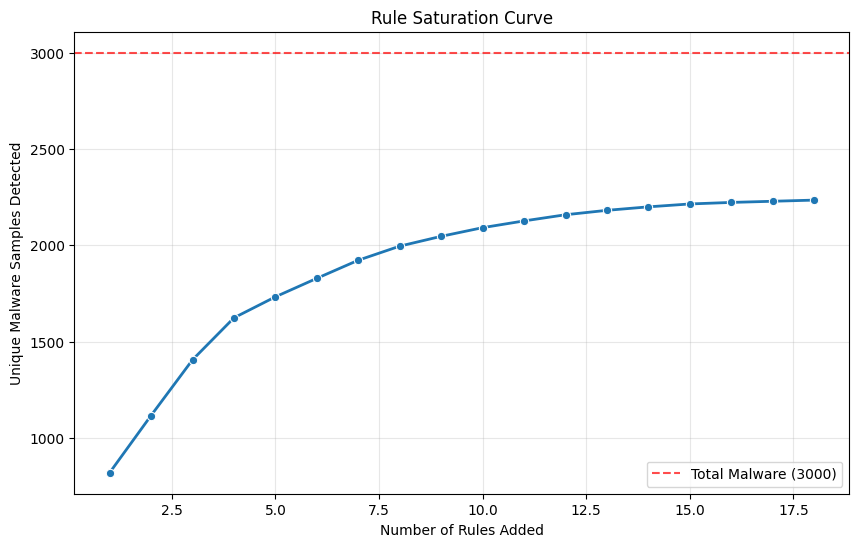

In [ ]:
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- Configuration ---
DATA_CSV = "Balanced_Malware_Dataset_500.csv"
RULES_DIR = "outputs/rules/validated"
OUTPUT_DIR = "outputs/final_optimization"
NEW_TP_THRESHOLD = 5  # Minimum new detections required to keep a rule

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

def load_data(csv_path):
    """
    Loads the dataset and prepares binary labels for evaluation.
    """
    print(f"[INFO] Loading data from {csv_path}...")
    
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Dataset not found: {csv_path}")

    df = pd.read_csv(csv_path)
    
    # Standardize description column
    if 'Description' not in df.columns and 'combined_features' in df.columns:
        df.rename(columns={'combined_features': 'Description'}, inplace=True)
        
    df['Description'] = df['Description'].astype(str).fillna("")
    
    # Create binary label: 0 is benign, everything else is malware
    if 'Type' in df.columns:
        df['is_malware'] = (df['Type'] != 0).astype(int)
    else:
        raise KeyError("Dataset missing 'Type' column for label generation.")
    
    malware_count = df['is_malware'].sum()
    benign_count = len(df) - malware_count
    
    print(f"[INFO] Dataset loaded successfully.")
    print(f"       Total Samples: {len(df)}")
    print(f"       Malware:       {malware_count}")
    print(f"       Benign:        {benign_count}")

    return df

def build_match_matrix(df, rules_dir):
    """
    Compiles all YARA rules and scans the dataset in a single pass.
    Returns a binary DataFrame where rows=samples, columns=rules.
    """
    print(f"\n[INFO] Scanning dataset with rules from {rules_dir}...")
    
    try:
        import yara
    except ImportError:
        print("[ERROR] 'yara-python' is not installed. Run: pip install yara-python")
        return None

    # 1. Read rule content
    rule_files = glob.glob(os.path.join(rules_dir, "*.yar"))
    if not rule_files:
        print("[ERROR] No .yar files found in the specified directory.")
        return None

    sources = {}
    for path in rule_files:
        rule_name = os.path.basename(path).replace('.yar', '')
        try:
            with open(path, 'r', encoding='utf-8') as f:
                sources[rule_name] = f.read()
        except Exception as e:
            print(f"[WARNING] Skipping {rule_name}: {e}")

    print(f"[INFO] Loaded {len(sources)} valid rule files.")

    # 2. Compile rules into a single engine
    try:
        compiled_rules = yara.compile(sources=sources)
    except yara.SyntaxError as e:
        print(f"[ERROR] YARA compilation failed: {e}")
        return None

    # 3. Scan samples
    rule_names = list(sources.keys())
    matrix = pd.DataFrame(0, index=df.index, columns=rule_names)
    
    print(f"[INFO] Scanning {len(df)} text logs...")
    
    for idx, text in df['Description'].items():
        try:
            matches = compiled_rules.match(data=text)
            for match in matches:
                # The 'namespace' attribute corresponds to the dictionary key (rule name)
                triggered_rule = match.namespace
                if triggered_rule in matrix.columns:
                    matrix.at[idx, triggered_rule] = 1
        except Exception:
            continue

    print("[INFO] Match matrix construction complete.")
    return matrix

def optimize_rules(match_matrix, df):
    """
    Executes a Greedy Set Cover algorithm to select the minimal set of rules
    that maximize malware coverage.
    """
    print("\n[INFO] Starting Greedy Rule Selection...")
    
    malware_indices = set(df[df['is_malware'] == 1].index)
    available_rules = list(match_matrix.columns)
    
    selected_rules = []
    caught_indices = set()
    history = []
    
    while True:
        best_rule = None
        best_gain = 0
        best_new_hits = set()
        
        # Evaluate unselected rules
        candidates = [r for r in available_rules if r not in selected_rules]
        
        for rule in candidates:
            # Get samples caught by this rule
            hits = set(match_matrix.index[match_matrix[rule] == 1])
            
            # Filter for true positives only
            malware_hits = hits.intersection(malware_indices)
            
            # Calculate marginal gain (unique new detections)
            new_hits = malware_hits - caught_indices
            gain = len(new_hits)
            
            if gain > best_gain:
                best_gain = gain
                best_rule = rule
                best_new_hits = new_hits
        
        # Stopping condition
        if best_rule is None or best_gain < NEW_TP_THRESHOLD:
            print(f"[INFO] Optimization stopped. Best remaining rule adds {best_gain} detections (Threshold: {NEW_TP_THRESHOLD}).")
            break
            
        # Update state
        selected_rules.append(best_rule)
        caught_indices.update(best_new_hits)
        
        current_tp = len(caught_indices)
        total_malware = len(malware_indices)
        coverage = (current_tp / total_malware) * 100
        
        history.append({
            'Step': len(selected_rules),
            'Selected_Rule': best_rule,
            'New_TP': best_gain,
            'Cumulative_TP': current_tp,
            'Coverage_Percent': round(coverage, 2)
        })
        
        print(f"Step {len(selected_rules):02d}: Added '{best_rule}' (+{best_gain} New TPs) -> Total Coverage: {coverage:.2f}%")

    return pd.DataFrame(history)

if __name__ == "__main__":
    # 1. Load Data
    try:
        df = load_data(DATA_CSV)
    except Exception as e:
        print(f"[CRITICAL] Failed to load data: {e}")
        exit(1)

    # 2. Build Matrix
    matrix = build_match_matrix(df, RULES_DIR)
    
    if matrix is not None and not matrix.empty:
        # 3. Run Optimization
        optimization_df = optimize_rules(matrix, df)
        
        if not optimization_df.empty:
            # 4. Save Results
            csv_path = os.path.join(OUTPUT_DIR, "optimized_rule_sequence.csv")
            optimization_df.to_csv(csv_path, index=False)
            print(f"\n[INFO] Optimized rule list saved to: {csv_path}")
            
            # 5. Plot Saturation Curve
            plt.figure(figsize=(10, 6))
            sns.lineplot(data=optimization_df, x='Step', y='Cumulative_TP', marker='o', linewidth=2)
            
            total_mal = df['is_malware'].sum()
            plt.axhline(y=total_mal, color='r', linestyle='--', alpha=0.7, label=f'Total Malware ({total_mal})')
            
            plt.title('Rule Saturation Curve')
            plt.xlabel('Number of Rules Added')
            plt.ylabel('Unique Malware Samples Detected')
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            plot_path = os.path.join(OUTPUT_DIR, "saturation_curve.png")
            plt.savefig(plot_path)
            print(f"[INFO] Performance graph saved to: {plot_path}")
            
            print("\nFinal Recommended Rules (Top 5)")
            print("-" * 50)
            print(optimization_df[['Selected_Rule', 'New_TP', 'Coverage_Percent']].head(5).to_string(index=False))
            print("-" * 50)
        else:
            print("[WARNING] Optimization yielded no rules. Check rule matching logic.")
    else:
        print("[ERROR] Matrix build failed or no rules matched any samples.")

In [47]:


# Configuration
OPTIMIZED_LIST_CSV = "outputs/final_optimization/optimized_rule_sequence.csv"
RULES_DIR = "outputs/rules/validated"

def compile_optimized_rules(rule_list_csv, rules_dir):
    """
    Reads the optimized rule list and compiles the corresponding YARA rules.
    """
    print("[INFO] Compiling optimized rule set...")
    
    if not os.path.exists(rule_list_csv):
        raise FileNotFoundError(f"Optimization list not found at: {rule_list_csv}")
        
    # Load selected rules
    opt_df = pd.read_csv(rule_list_csv)
    selected_rule_names = opt_df['Selected_Rule'].tolist()
    
    sources = {}
    
    for rule_name in selected_rule_names:
        # Ensure correct file extension
        filename = rule_name if rule_name.lower().endswith(".yar") else f"{rule_name}.yar"
        rule_path = os.path.join(rules_dir, filename)
        
        # specific fallback for naming inconsistencies
        if not os.path.exists(rule_path):
            clean_name = filename.replace("rule ", "").strip()
            rule_path = os.path.join(rules_dir, clean_name)

        if os.path.exists(rule_path):
            with open(rule_path, 'r', encoding='utf-8') as f:
                sources[filename] = f.read()
        else:
            print(f"[WARNING] Rule file not found: {filename}")

    if not sources:
        raise ValueError("No valid rule files found from the optimized list.")

    print(f"[INFO] Successfully loaded {len(sources)} / {len(selected_rule_names)} rules.")

    try:
        rules = yara.compile(sources=sources)
        return rules
    except yara.SyntaxError as e:
        print(f"[ERROR] Compilation failed: {e}")
        return None

def evaluate_performance(rules, df):
    """
    Scans the test dataframe using compiled YARA rules and calculates metrics.
    """
    print(f"[INFO] Scanning test set ({len(df)} samples)...")
    
    # Determine text column
    if 'Description' in df.columns:
        text_column = 'Description'
    elif 'combined_features' in df.columns:
        text_column = 'combined_features'
    else:
        raise KeyError("Dataframe missing 'Description' or 'combined_features' column.")
        
    # Determine ground truth column
    if 'label' in df.columns:
        y_true = df['label'].values
    elif 'Type' in df.columns:
        # Convert multiclass (0=Benign, >0=Malware) to binary
        y_true = df['Type'].apply(lambda x: 0 if x == 0 else 1).values
    else:
        raise KeyError("Dataframe missing 'label' or 'Type' column.")
    
    y_pred = []
    
    for text in df[text_column]:
        try:
            matches = rules.match(data=str(text))
            y_pred.append(1 if matches else 0)
        except yara.Error:
            y_pred.append(0) 
            
    # Calculate Metrics
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Report
    print("\nFinal Performance Metrics")
    print("-" * 30)
    print(f"Accuracy:  {accuracy:.2%}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print("-" * 30)
    print(f"True Positives  (Malware Detected): {tp}")
    print(f"False Positives (False Alarms):     {fp}")
    print(f"False Negatives (Missed Malware):   {fn}")
    print(f"True Negatives  (Correctly Safe):   {tn}")

if __name__ == "__main__":
    # Ensure test_df is available in the environment
    if 'test_df' in locals() and not test_df.empty:
        optimized_rules = compile_optimized_rules(OPTIMIZED_LIST_CSV, RULES_DIR)
        if optimized_rules:
            evaluate_performance(optimized_rules, test_df)
    else:
        print("[ERROR] 'test_df' is not defined or empty. Please ensure the test dataset is loaded.")

[INFO] Compiling optimized rule set...
[INFO] Successfully loaded 18 / 18 rules.
[INFO] Scanning test set (976 samples)...

Final Performance Metrics
------------------------------
Accuracy:  82.38%
Precision: 0.9477
Recall:    0.7550
F1-Score:  0.8404
------------------------------
True Positives  (Malware Detected): 453
False Positives (False Alarms):     25
False Negatives (Missed Malware):   147
True Negatives  (Correctly Safe):   351
